# Reinforcement Learning

# 4. Online control

This notebook presents the **online control** of an agent by SARSA and Q-learning.


In [1]:
import sys
from pathlib import Path

lib_path = str(Path.cwd().parent)

if lib_path not in sys.path:
    sys.path.append(lib_path)
print(sys.path)

['C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'd:\\Code\\Reinforcement Learning\\venv', '', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\Code\\Reinforcement Learning']


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from lib.model import TicTacToe, Nim, ConnectFour
from lib.agent import Agent, OnlineControl
from lib.dynamic import ValueIteration

## To do

- Complete the class `SARSA` and test it on Tic-Tac-Toe.
- Complete the class `QLearning` and test it on Tic-Tac-Toe.
- Compare these algorithms on Tic-Tac-Toe (play first) and Nim (play second), using a random adversary, then a perfect adversary. Comment your results.
- Test these algorithms on Connect 4 against a random adversary. Comment your results.


## SARSA


In [4]:
class SARSA(OnlineControl):
    """Online control by SARSA."""

    def update_values(self, state=None, horizon=100, epsilon=0.5):
        """Learn the action-value function online."""
        self.model.reset(state)
        state = self.model.state
        if not self.model.is_terminal(state):
            action = self.randomize_best_action(state, epsilon=epsilon)
            for _ in range(horizon):
                code = self.model.encode(state)
                self.action_count[code][action] += 1
                reward, stop = self.model.step(action)
                # to be modified (get sample Avg Gain)
                # begin
                # check if the new state is terminal
                # take new action and get the next state
                next_state = self.model.state
                code_next = self.model.encode(next_state)
                if not stop:
                    next_action = self.randomize_best_action(
                        self.model.state, epsilon=epsilon
                    )
                    gain = (
                        reward + self.gamma * self.action_value[code_next][next_action]
                    )
                else:
                    gain = reward
                # end
                diff = gain - self.action_value[code][action]
                count = self.action_count[code][action]
                self.action_value[code][action] += diff / count
                # to be modified (update state and action)
                # begin
                if stop:
                    break
                state = next_state
                action = next_action
                # end

## Q-learning


In [5]:
class QLearning(OnlineControl):
    """Online control by Q-learning."""

    def update_values(self, state=None, horizon=100, epsilon=0.5):
        """Learn the action-value function online."""
        self.model.reset(state)
        state = self.model.state
        # to be completed
        if not self.model.is_terminal(state):
            for _ in range(horizon):
                action = self.randomize_best_action(state, epsilon=epsilon)

                code = self.model.encode(state)
                self.action_count[code][action] += 1
                reward, stop = self.model.step(action)

                next_state = self.model.state
                if not stop:
                    code_next = self.model.encode(next_state)
                    next_action = self.randomize_best_action(
                        self.model.state, epsilon=0
                    )
                    gain = (
                        reward + self.gamma * self.action_value[code_next][next_action]
                    )
                else:
                    gain = reward

                diff = gain - self.action_value[code][action]
                count = self.action_count[code][action]
                self.action_value[code][action] += diff / count
                if stop:
                    break
                state = next_state

## To do


### Tic-Tac-Toe


In [6]:
game = TicTacToe()

In [7]:
agent = Agent(game)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([29, 12, 59]))

#### Test SARSA on Tic-Tac-Toe vs random adversary


In [8]:
algo = SARSA(game)

n_games = 10001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.01)

    if i % 100 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(1))

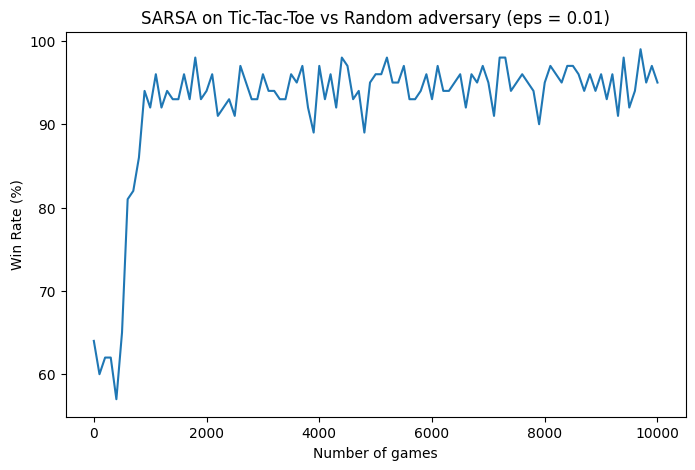

In [9]:
plt.figure(figsize=(8, 5))
plt.title("SARSA on Tic-Tac-Toe vs Random adversary (eps = 0.01)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100],
    labels=[0, 2000, 4000, 6000, 8000, 10000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [10]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([0, 1]), array([ 1, 99]))

We can see that after around 2000 games, the win-rate stabilizes around 90%.

This is expected as the random adversary is not very strong and the agent can learn to win most of the time.


#### Test Q-learning on Tic-Tac-Toe vs random adversary


In [11]:
algo = QLearning(game)

n_games = 10001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.1)

    if i % 100 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(1))

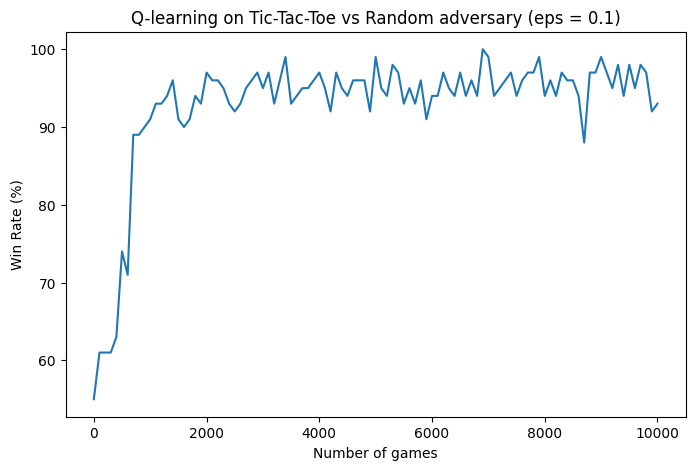

In [12]:
plt.figure(figsize=(8, 5))
plt.title("Q-learning on Tic-Tac-Toe vs Random adversary (eps = 0.1)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100],
    labels=[0, 2000, 4000, 6000, 8000, 10000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [13]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([ 3,  3, 94]))

We can see that with Q-learning, the agent learns a bit slower than with SARSA, with a comparable win-rate.

Again, this is expected as we are playing against a random adversary.


#### Test SARSA on Tic-Tac-Toe vs perfect adversary


In [14]:
algo = ValueIteration(game)
_, adversary_policy = algo.get_perfect_players()

game = TicTacToe(adversary_policy=adversary_policy)

In [15]:
algo = SARSA(game)

n_games = 10001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.01)

    if i % 100 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(-1) * -1)

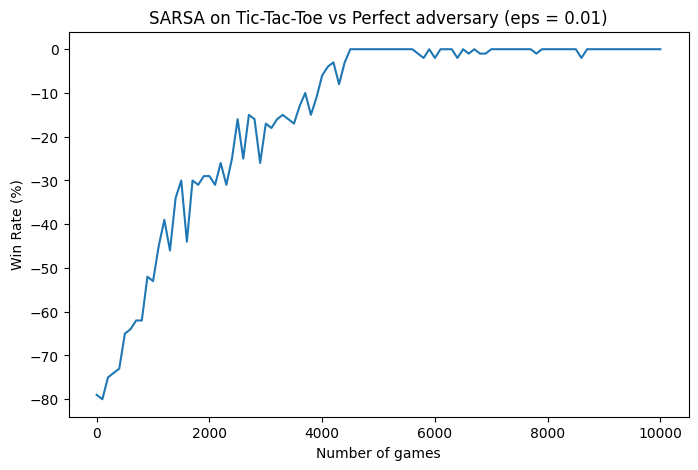

In [16]:
plt.figure(figsize=(8, 5))
plt.title("SARSA on Tic-Tac-Toe vs Perfect adversary (eps = 0.01)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100],
    labels=[0, 2000, 4000, 6000, 8000, 10000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [17]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([0]), array([100]))

This time the win-rate stabilizes around 0.

It is expected as the adversary is perfect and the agent cannot win, even by playing first.


#### Test Q-learning on Tic-Tac-Toe vs perfect adversary


In [18]:
algo = QLearning(game)

n_games = 10001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.5)

    if i % 100 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(-1) * -1)

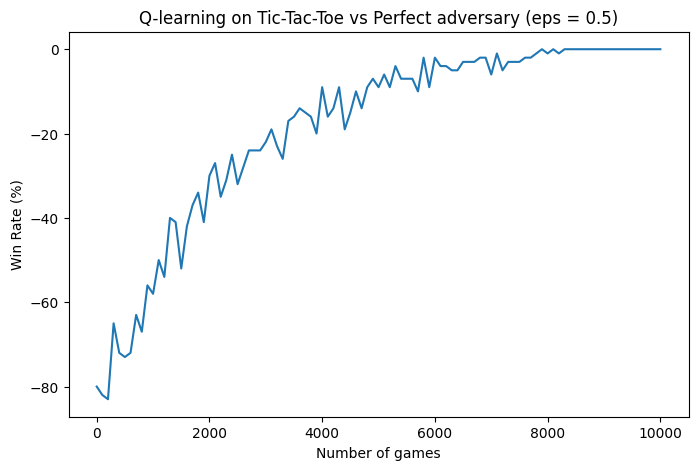

In [19]:
plt.figure(figsize=(8, 5))
plt.title("Q-learning on Tic-Tac-Toe vs Perfect adversary (eps = 0.5)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100],
    labels=[0, 2000, 4000, 6000, 8000, 10000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [20]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([0]), array([100]))

Q-learning behaves similarly to SARSA, as expected, but converges to a win-rate of 0 slower.


### Nim


In [21]:
game = Nim(play_first=False)

In [22]:
agent = Agent(game)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([46, 54]))

#### Test SARSA on Nim vs random adversary


In [23]:
algo = SARSA(game)

n_games = 10001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.01)

    if i % 100 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(1))

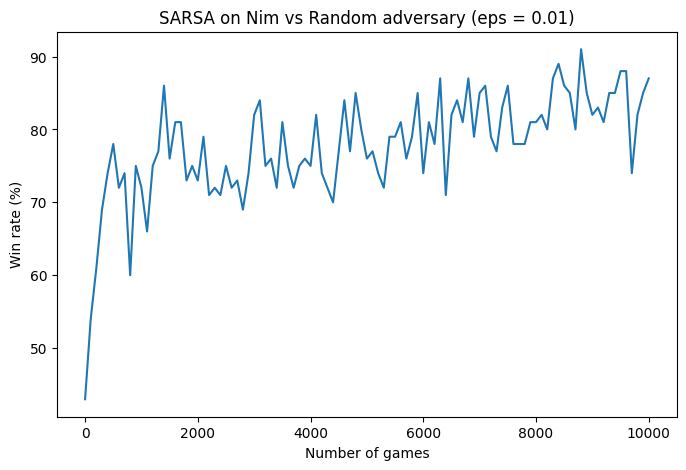

In [24]:
plt.figure(figsize=(8, 5))
plt.title("SARSA on Nim vs Random adversary (eps = 0.01)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100],
    labels=[0, 2000, 4000, 6000, 8000, 10000],
)
plt.ylabel("Win rate (%)")
plt.plot(win_rates)
plt.show()

In [25]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([13, 87]))

Similarly to Tic-Tac-Toe, the agent learns to win most of the time against a random adversary, but is not able to win all the time.


#### Test Q-learning on Nim vs random adversary


In [26]:
algo = QLearning(game)

n_games = 10001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.1)

    if i % 100 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(1))

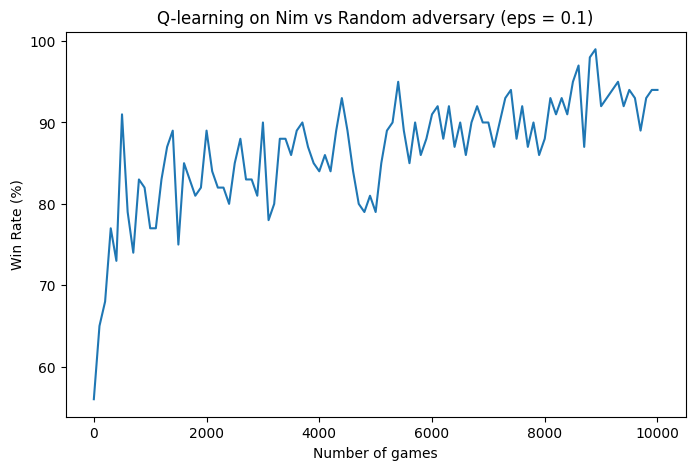

In [27]:
plt.figure(figsize=(8, 5))
plt.title("Q-learning on Nim vs Random adversary (eps = 0.1)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100],
    labels=[0, 2000, 4000, 6000, 8000, 10000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [28]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([10, 90]))

Q-learning behaves similarly to SARSA, as expected.


#### Test SARSA on Nim vs perfect adversary


In [29]:
algo = ValueIteration(game)
_, adversary_policy = algo.get_perfect_players()

game = Nim(adversary_policy=adversary_policy, play_first=False)

In [30]:
algo = SARSA(game)

n_games = 10001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.01)

    if i % 100 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(1))

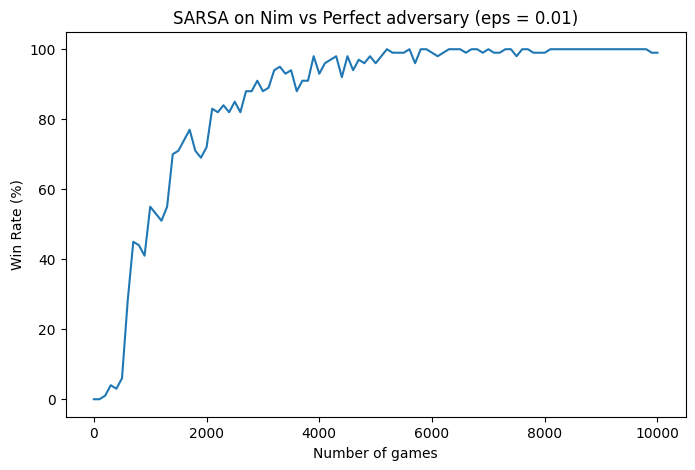

In [31]:
plt.figure(figsize=(8, 5))
plt.title("SARSA on Nim vs Perfect adversary (eps = 0.01)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100],
    labels=[0, 2000, 4000, 6000, 8000, 10000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [32]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([1]), array([100]))

Oddly, the agent is able to always win against a perfect adversary.

Analyzing the results, we can see that the agent learns to always win by playing second, which is a known strategy in Nim.
Moreover, the adversary is perfect and deterministic, so the agent can learn to always win by playing second.


#### Test Q-learning on Nim vs perfect adversary


In [33]:
algo = QLearning(game)

n_games = 10001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.01)

    if i % 100 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(1))

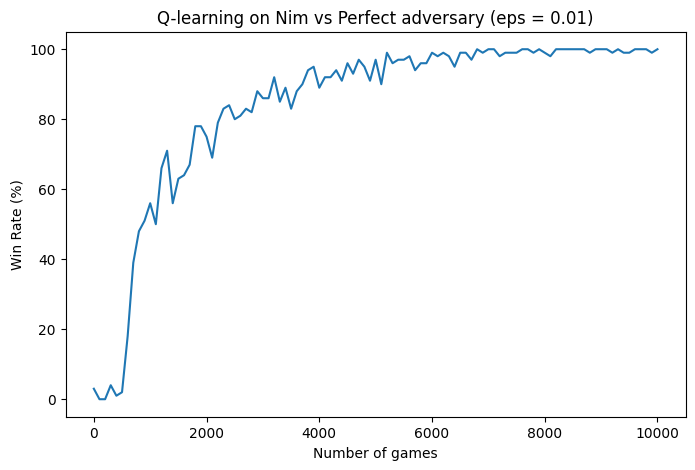

In [34]:
plt.figure(figsize=(8, 5))
plt.title("Q-learning on Nim vs Perfect adversary (eps = 0.01)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 20, 40, 60, 80, 100],
    labels=[0, 2000, 4000, 6000, 8000, 10000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [35]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([1]), array([100]))

Also with Q-learning, the agent is able to always win against a perfect adversary on Nim, by playing second.


### Connect Four


In [36]:
game = ConnectFour()

In [37]:
agent = Agent(game)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([48, 52]))

#### Test SARSA on Connect Four vs random adversary


In [38]:
algo = SARSA(game)

n_games = 5001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.01)

    if i % 200 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(1))

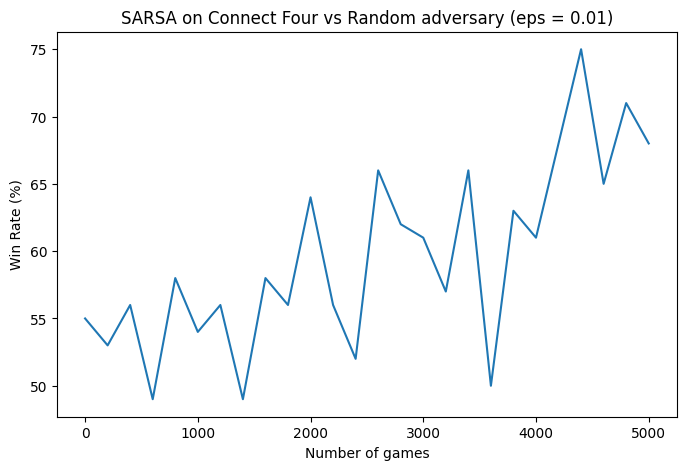

In [39]:
plt.figure(figsize=(8, 5))
plt.title("SARSA on Connect Four vs Random adversary (eps = 0.01)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 5, 10, 15, 20, 25],
    labels=[0, 1000, 2000, 3000, 4000, 5000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [40]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([34, 66]))

We see an increase in the win-rate over time, but the learning is slow.

This is expected as the state space is much larger than in Tic-Tac-Toe or Nim.


#### Test Q-learning on Connect Four vs random adversary


In [41]:
algo = QLearning(game)

n_games = 5001
win_rates = []

for i in range(n_games):
    algo.update_values(epsilon=0.1)

    if i % 200 == 0:
        policy = algo.get_policy()
        agent = Agent(game, policy=policy)
        gains = agent.get_gains()
        win_rates.append(gains.count(1))

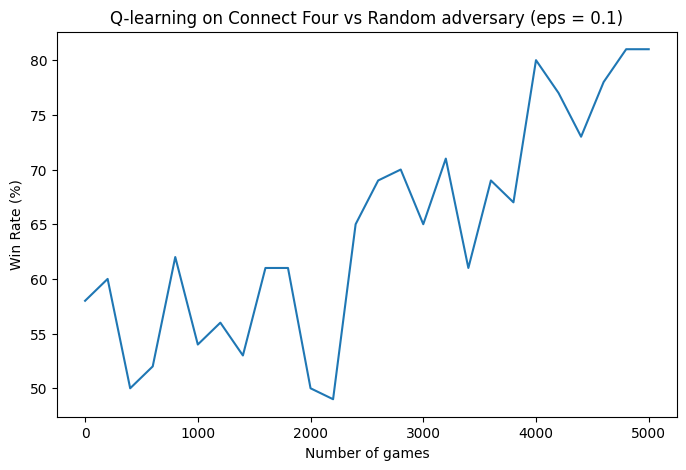

In [42]:
plt.figure(figsize=(8, 5))
plt.title("Q-learning on Connect Four vs Random adversary (eps = 0.1)")
plt.xlabel("Number of games")
plt.xticks(
    ticks=[0, 5, 10, 15, 20, 25],
    labels=[0, 1000, 2000, 3000, 4000, 5000],
)
plt.ylabel("Win Rate (%)")
plt.plot(win_rates)
plt.show()

In [43]:
policy = algo.get_policy()
agent = Agent(game, policy=policy)
np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([27, 73]))

Similarly to SARSA, Q-learning learns slowly against a random adversary, but we can nevertheless see an increase in the win-rate over time.
